# Initialize Language_Table env

In [ ]:
!pip install git+https://github.com/google-research/language-table.git
!pip install mediapy
!pip install matplotlib==3.1.3

  Cloning https://github.com/google-research/language-table.git to /tmp/pip-req-build-yhi9tpa3
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/language-table.git /tmp/pip-req-build-yhi9tpa3
  Resolved https://github.com/google-research/language-table.git to commit 9d27322fd7abee9f229d32b1a993c41ec6fcd98c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 kB 25.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.5/80.5 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11757312 sha256=9bc5a3ac751552cfa97c34590646f50582e36f611cd20814f750ddea5f83b229
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.8.1 requires matplotlib>=3.5.0, but you have m

# Import Modules

In [ ]:
import os

import tensorflow_datasets as tfds
import cv2
import mediapy
import numpy as np
import torch

from language_table.environments import blocks
from language_table.environments import language_table
from language_table.environments.rewards import block2block
from matplotlib import pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset

import warnings
warnings.filterwarnings("ignore")

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


# Load Language Table Dataset

In [ ]:
DATASET_VERSION = '0.0.1'
DATASET_NAME = 'language_table_blocktoblock_sim'  # CHANGEME: change this to load another dataset.

dataset_directories = {
    'language_table_blocktoblock_sim': 'gs://gresearch/robotics/language_table_blocktoblock_sim'
}

dataset_path = os.path.join(dataset_directories[DATASET_NAME], DATASET_VERSION)
print(dataset_path)

gs://gresearch/robotics/language_table_blocktoblock_sim/0.0.1


In [ ]:
builder = tfds.builder_from_directory(dataset_path)
episode_ds = builder.as_dataset(split='train')

print(episode_ds.element_spec)

{'episode_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'steps': DatasetSpec({'action': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'is_first': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_last': TensorSpec(shape=(), dtype=tf.bool, name=None), 'is_terminal': TensorSpec(shape=(), dtype=tf.bool, name=None), 'observation': {'effector_target_translation': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'effector_translation': TensorSpec(shape=(2,), dtype=tf.float32, name=None), 'instruction': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'rgb': TensorSpec(shape=(360, 640, 3), dtype=tf.uint8, name=None)}, 'reward': TensorSpec(shape=(), dtype=tf.float32, name=None)}, TensorShape([]))}


In [ ]:
dataset = tfds.as_numpy(episode_ds)
dataset

# Decode instruction

In [ ]:
def decode_inst(inst):
  """Utility to decode encoded language instruction"""
  return bytes(inst[np.where(inst != 0)].tolist()).decode("utf-8")

# Create Torch Dataset

In [ ]:
episode_ds = episode_ds.flat_map(lambda x: x['steps'])  # get the dataset as individual steps

instructions = []
rgb = []
for n, item in enumerate(episode_ds):
    instruction = item['observation']['instruction'].numpy()
    image = item['observation']['rgb'].numpy()

    instruction = torch.from_numpy(instruction)
    instructions.append(decode_inst(instruction))

    image = torch.from_numpy(image)
    rgb.append([image])
    if n==45:
      break


In [ ]:
class MyDataset(Dataset):
    def __init__(self, instruction, image):

        self.instructions = instruction
        self.images = image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):

        instruction = self.instructions[idx]
        image = self.images[idx]

        return instruction, image

In [ ]:
TrainDataset = MyDataset(instructions, rgb)
TestDataset = MyDataset(instructions, rgb)

batch_size = 32
TrainLoader = DataLoader(TrainDataset, batch_size=batch_size, shuffle=False)
TestLoader = DataLoader(TestDataset, batch_size=batch_size, shuffle=False)

In [ ]:
next(iter(TrainLoader))[0][0]

'slide the yellow star next to the green star'

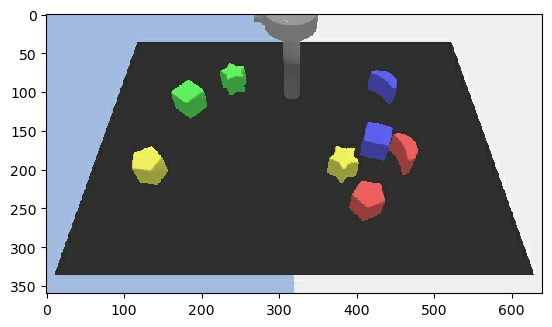

In [ ]:
plt.imshow(next(iter(TrainLoader))[1][0][0])